In [1]:
%matplotlib inline 
import matplotlib
import keras
import sys
import os
from glob import glob
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("data")
from models.unet import *
from data.isbi import ISBI_2012
from data.dataset import Dataset
from callbacks import ImageHistory

Using TensorFlow backend.


## Directories

In [2]:
isbi_dataset_location = './data/datasets/isbi-2012'
tensor_board_directory = './logs'
weight_file = './weights.hdf5'

## Parameters

In [3]:
learning_rate = 1e-4
input_shape=(512,512,1)
loss = 'binary_crossentropy'
steps_per_epoch = 1000
epochs = 3
batch_size = 5
start_epoch = 1
last_step = 10
clear_all = False

## Clear data from previous executions if needed

In [4]:
if clear_all:
    if os.path.exists(weight_file):
        os.remove(weight_file)
    files = glob(tensor_board_directory +'/*')
    for f in files:
        os.remove(f)

## Setup dataset

In [5]:
dataset = ISBI_2012(dataset_path=isbi_dataset_location)

## Setup optimizer

In [6]:
optimizer = keras.optimizers.Adam(lr = learning_rate)

## Buils model

In [7]:
builder = Unet(input_shape=input_shape)
model = builder.build_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 640         input[0][0]                      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 64) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

## Dataset generators

In [8]:
train_generator = dataset.generator('training', batch_size=batch_size)
valid_generator = dataset.generator('validation', batch_size=1)

## Metrics

In [9]:
def pixel_difference(y_true, y_pred):
    '''
    Custom metrics for comparison of images
    pixel by pixel. 
    '''
    cof = 100/(input_shape[0]*input_shape[1]*batch_size)
    return cof*K.sum(K.abs(y_true - y_pred))

metrics = ['accuracy', pixel_difference]

## Compile model

In [10]:
model.compile(optimizer=optimizer, loss = loss, metrics = metrics)

## Callbacks

In [11]:
# tensor board
tensorboard = keras.callbacks.TensorBoard(log_dir=tensor_board_directory, histogram_freq=0, write_graph=True, write_images=True, update_freq=100)
# image prediction history to be shown in the Tensor board
v_generator = dataset.generator('validation', batch_size=1)
v_data = [next(v_generator) for item in range(3)]
image_history = ImageHistory(tensor_board_dir=tensor_board_directory, data=v_data, last_step=last_step, draw_interval=100)
# model saving at end of an epoch
model_checkpoint = keras.callbacks.ModelCheckpoint(weight_file, monitor='loss',verbose=1, save_best_only=True)

## Load weights from previous steps

In [12]:
if os.path.isfile(weight_file):
    print('load weights')
    model.load_weights(weight_file)

load weights


## Train Model

In [13]:
model.fit_generator(generator=train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, initial_epoch=start_epoch,
                    validation_data=valid_generator, validation_steps=1,
                    callbacks=[model_checkpoint, tensorboard, image_history])

Epoch 2/3
   2/1000 [..............................] - ETA: 5:37:45 - loss: 0.1701 - acc: 0.8805 - pixel_difference: 8.9132

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (3.755732). Check your callbacks.
  % delta_t_median)


1000/1000 [==============================] - 3431s 3s/step - loss: 0.1048 - acc: 0.9064 - pixel_difference: 5.0271 - val_loss: 0.2773 - val_acc: 0.9291 - val_pixel_difference: 1.5953

Epoch 00002: loss improved from inf to 0.10477, saving model to ./weights.hdf5
Epoch 3/3
1000/1000 [==============================] - 3371s 3s/step - loss: 0.0723 - acc: 0.9171 - pixel_difference: 3.0026 - val_loss: 0.2755 - val_acc: 0.9257 - val_pixel_difference: 1.6251

Epoch 00003: loss improved from 0.10477 to 0.07224, saving model to ./weights.hdf5


## Explore results

In [14]:
def generate_segmentation_masks(model, input_images):
    '''
    function generates segmentation masks for list of
    input images. Returns a list of segmentation masks
    represented as a numpy array
    '''
    masks = []
    for image in input_images:
        mask = model.predict(image)
        masks.append(mask)
    return masks

### Generate segmentation masks

In [15]:
builder = Unet(input_shape=input_shape)
model = builder.build_model()
model.load_weights(weight_file)

number_of_test_images = 3
t_generator = dataset.generator('test', batch_size=1)
t_data = [next(t_generator) for item in range(number_of_test_images)]
images = [item[0] for item in t_data]
labels = [item[1] for item in t_data]
masks = generate_segmentation_masks(model, images)

### Compute pixelwise differences between masks and labels

In [16]:
for ind in range(number_of_test_images):
    pixel_dif = np.sum(np.abs(masks[ind] - labels[ind]))/(masks[ind].shape[1]*masks[ind].shape[2]/100)
    print('image %d: %.2f %%' % (ind+1, pixel_dif))

image 1: 10.63 %
image 2: 9.61 %
image 3: 9.65 %


### Visuslization of the segmentation masks

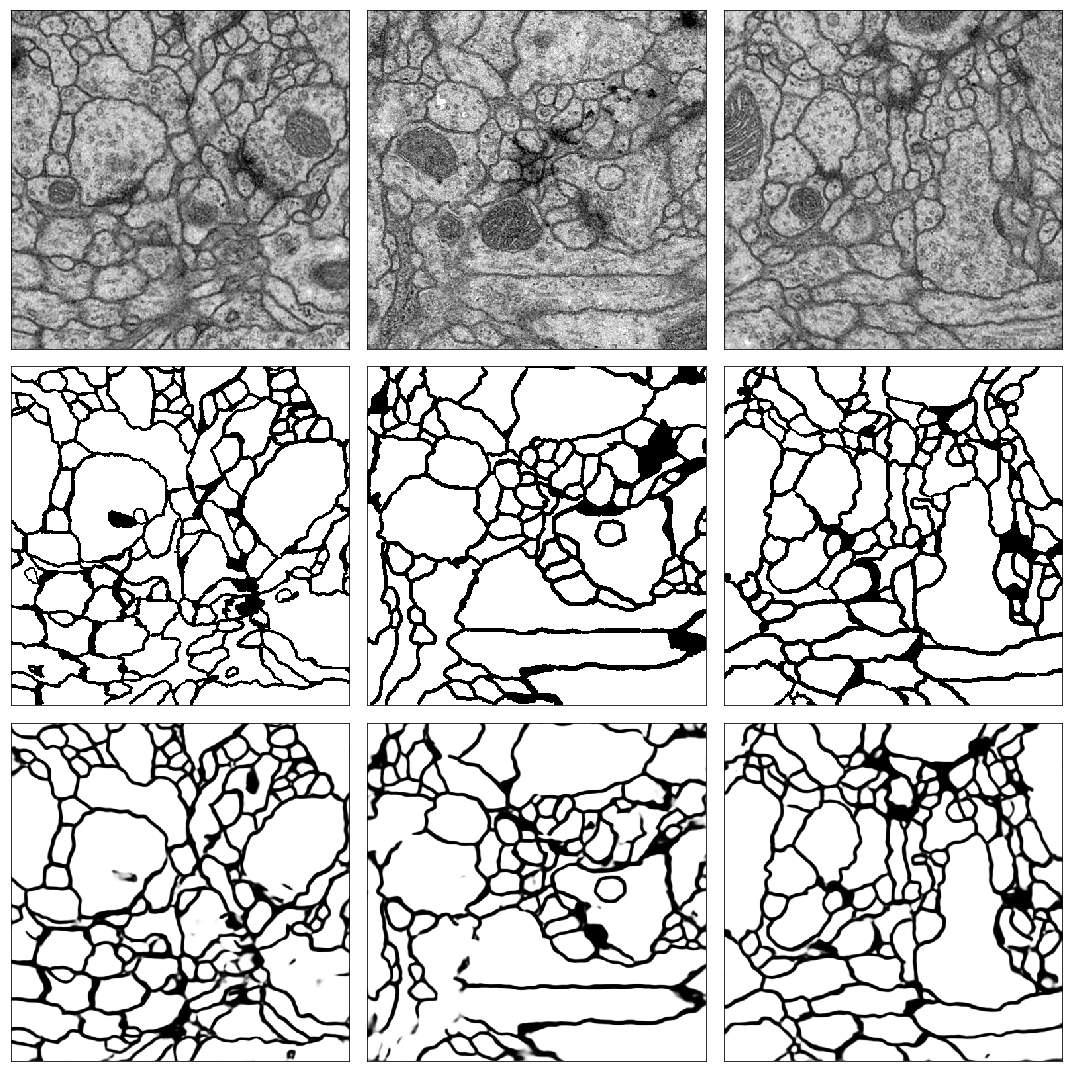

In [17]:
n_images = len(images)
cols = n_images
rows = 3
plt.figure(figsize=(15, 15))
for i in range(n_images*rows):
    if i<n_images:
        img = images[i][0,:,:,0]
    elif i<n_images*2:
        img = labels[i-n_images][0,:,:,0]
    else:
        img = masks[i-n_images*2][0,:,:,0]
    ax = plt.subplot(rows, cols, i+1)
    plt.imshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()